# Testing the final model

In [1]:
import detectron2
import torch, torchvision
from utils.dataset import *
from utils.evaluation.evaluator import *
from utils.trainer import MTSDTrainer

from detectron2.data import DatasetCatalog
# from detectron2.utils.logger import setup_logger
# setup_logger()
# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from datetime import datetime
from utils.predictor import MTSDPredictor

# from detectron2_backbone import backbone
# from detectron2_backbone.config import add_backbone_config

#import the COCO Evaluator to use the COCO Metrics
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

In [2]:
#l_id_f="/home/pkost/workspace/inzynierka/inz/lbl_id_dict.pkl"
l_id_f="/home/pkos/workspace/inz/praca_inzynierska/lbl_id_map.pkl"
with open(l_id_f, 'rb') as f:
        lbl_id_map = pickle.load(f)
labels = list(lbl_id_map.keys())
len(labels)

109

In [3]:
ann_d="/mnt/CommonData/dataset/filtered_annotations_2/"
#img_d="/mnt/CommonData/dataset/images/"
img_d="/home/pkos/Desktop/mtsd_fully_annotated/images"
for d in ["train", "val"]:
    #id_f="/mnt/CommonData/dataset/splits/"+ d +".txt"
    #id_f="/mnt/CommonData/dataset/mtsd_fully_annotated/splits/"+ d +".txt"
    id_f="/home/pkos/Desktop/mtsd_fully_annotated/splits/" + d +".txt"
    
    if d=="train":
        DatasetCatalog.register("MTSD_"+d, 
                            lambda id_f=id_f, ann_d=ann_d, img_d=img_d, l_id_f=l_id_f: 
                                prepare_MTSD_for_detectron(id_f, ann_d, img_d, l_id_f))
    else:
        DatasetCatalog.register("MTSD_"+d, 
                            lambda id_f=id_f, ann_d=ann_d, img_d=img_d, l_id_f=l_id_f: 
                                prepare_MTSD_for_detectron(id_f, ann_d, img_d, l_id_f))
    MetadataCatalog.get("MTSD_" + d).set(thing_classes=labels)
    
signs_metadata = MetadataCatalog.get("MTSD_train")
#later, to access the data:
#data: List[Dict] = DatasetCatalog.get("my_dataset")

In [4]:
#l.iteracji:(N / B) * E, where N stands for Number of Images, B stands for Batch Size, and E means epochs, or how many times we want our model to see each image.
cfg = get_cfg()

cfg.OUTPUT_DIR ="./tboard_logs/retinanet_2020-10-22T17:15_resize_br_ctrst_crop_70_85_rotate_lr0_001"#retinanet_2020-10-22T17:15_resize_br_ctrst_crop_70_85_rotate_lr0_001"
cfg.merge_from_file(cfg.OUTPUT_DIR + "/config.yml")
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0189999.pth") 

In [5]:
### cfg.DEVICE = "CPU"
# cfg.DATALOADER.NUM_WORKERS =1
# cfg.SOLVER.IMS_PER_BATCH = 1
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.3#0.1
cfg.INPUT.MIN_SIZE_TEST = 2448#3120#3024#(256,) #def 800
cfg.INPUT.MAX_SIZE_TEST = 3264#4160#4032#(1024,) #def 1333
#cfg.MODEL.RETINANET.NUM_CLASSES=109
print(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 2
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('MTSD_val',)
  TRAIN: ('MTSD_train',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: True
    SIZE: [0.7, 0.85]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 3264
  MAX_SIZE_TRAIN: 2048
  MIN_SIZE_TEST: 2448
  MIN_SIZE_TRAIN: (774, 808, 844, 880, 900, 910)
  MIN_SIZE_TRAIN_SAMPLING: choice
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32, 40.31747359663594, 50.79683366298238], [64, 80.63494719327188, 101.59366732596476], [128, 161.26989438654377, 203.18733465192952], [256, 322.53978877308754, 406.37466930385904], [512, 645.0795775

In [6]:
predictor = DefaultPredictor(cfg)

In [7]:
# %%time
# evaluator = COCOEvaluator("MTSD_val", cfg, False, "./output/")
# val_loader = build_detection_test_loader(cfg, "MTSD_val")
# torch.cuda.empty_cache()
# #Use the created predicted model in the previous step
# inference_on_dataset(predictor.model, val_loader, evaluator)

In [8]:
torch.cuda.empty_cache()
trainer = MTSDTrainer(cfg) 
#trainer.resume_or_load(resume=True)#(resume=False)

[11/24 17:22:34 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

In [9]:
results = trainer.test(cfg, predictor.model)

[11/24 17:22:48 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(2448, 2448), max_size=3264, sample_style='choice')]
[11/24 17:22:49 d2.data.build]: Distribution of instances among all 109 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
| information.. | 16           | information.. | 18           | information.. | 30           |
| information.. | 8            | information.. | 19           | information.. | 13           |
| information.. | 8            | information.. | 221          | information.. | 274          |
| regulatory-.. | 35           | regulatory-.. | 7            | regulatory-.. | 13           |
| regulatory-.. | 16           | regulatory-.. | 61           | regulatory-.. | 20           |
| regulatory-.. | 16           | regulatory-.. | 58           | regulatory-.. | 56     

In [10]:
dict(sorted(results['bbox'].items(), key=lambda item: -item[1]))

{'AP-regulatory--end-of-maximum-speed-limit-70--g1': 100.0,
 'AP-warning--curve-left--g2': 94.99332429661769,
 'AP-regulatory--priority-road--g1': 93.30953982194141,
 'AP-information--pedestrians-crossing--g1': 89.94249634898868,
 'AP-regulatory--stop--g1': 89.85993524484772,
 'AP-regulatory--keep-right--g4': 88.38897481624831,
 'AP-warning--traffic-signals--g1': 87.34165029301897,
 'AP-regulatory--no-overtaking--g5': 87.21510830781094,
 'AP-regulatory--yield--g1': 87.06374054642279,
 'AP-warning--other-danger--g1': 85.75694132427142,
 'AP-warning--texts--g1': 84.70169323329371,
 'AP-regulatory--no-stopping--g1': 84.53116277726377,
 'AP-regulatory--no-stopping--g2': 84.52779141686834,
 'AP-warning--kangaloo-crossing--g1': 83.43890887762517,
 'AP-regulatory--maximum-speed-limit-led--g1': 83.31678133488406,
 'AP-regulatory--no-parking--g1': 83.1360359539467,
 'AP-information--end-of-built-up-area--g1': 82.54950495049505,
 'AP-warning--curve-left--g1': 82.54145350545554,
 'AP-regulatory--

In [7]:
with open('dataset_dicts.pkl', 'rb') as f:
    dataset_dicts = pickle.load(f)

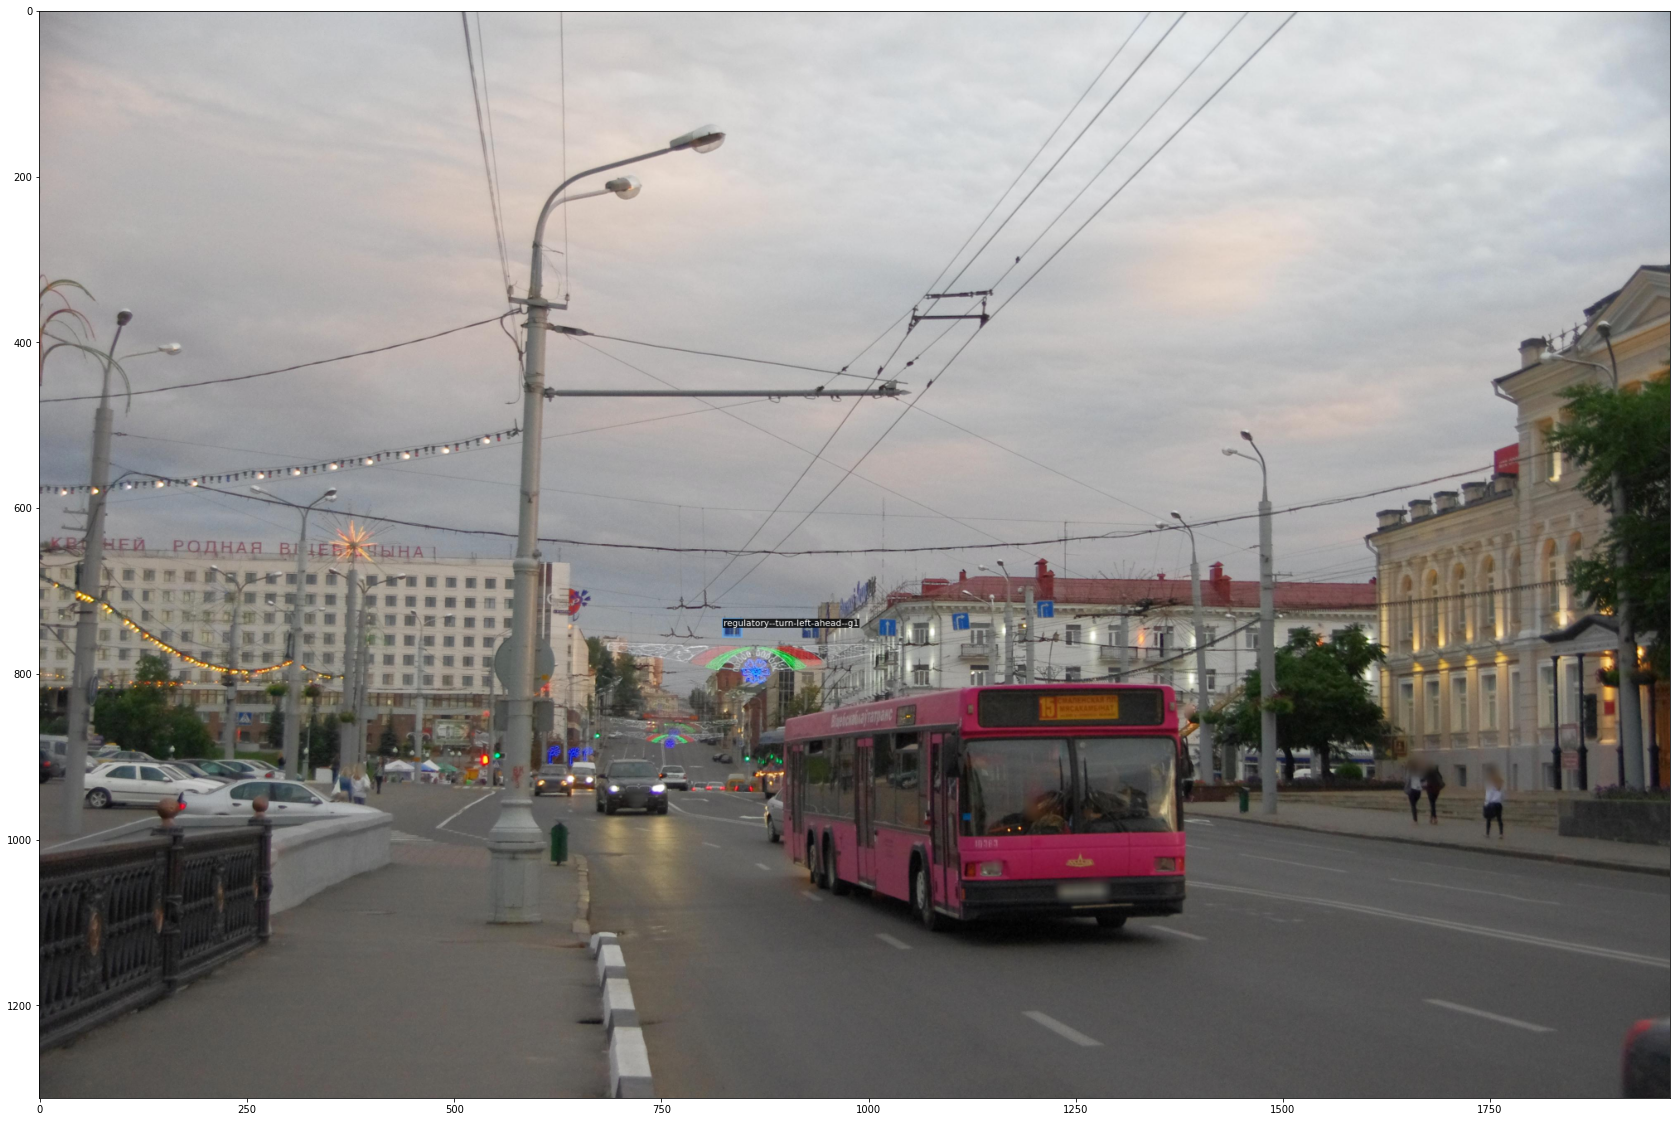

In [25]:
#plot sample image
plt.figure(figsize=(30,20))
d=random.sample(dataset_dicts, 1)[0]
img = cv2.imread(d["file_name"])
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
visualizer = Visualizer(img[:, :, ::-1], metadata=signs_metadata, scale=0.5)
out = visualizer.draw_dataset_dict(d)
plt.imshow(out.get_image())

{'instances': Instances(num_instances=4, image_height=2624, image_width=3936, fields=[pred_boxes: Boxes(tensor([[ 479.1363, 1691.9230,  513.7646, 1724.3661],
        [1840.4988, 1472.7755, 1882.9579, 1515.6232],
        [2202.6353, 1452.4825, 2245.8870, 1497.3163],
        [2026.7743, 1468.2537, 2068.7100, 1509.6138]], device='cuda:0')), scores: tensor([0.6442, 0.4706, 0.3908, 0.3362], device='cuda:0'), pred_classes: tensor([ 8, 52,  7, 52])])}


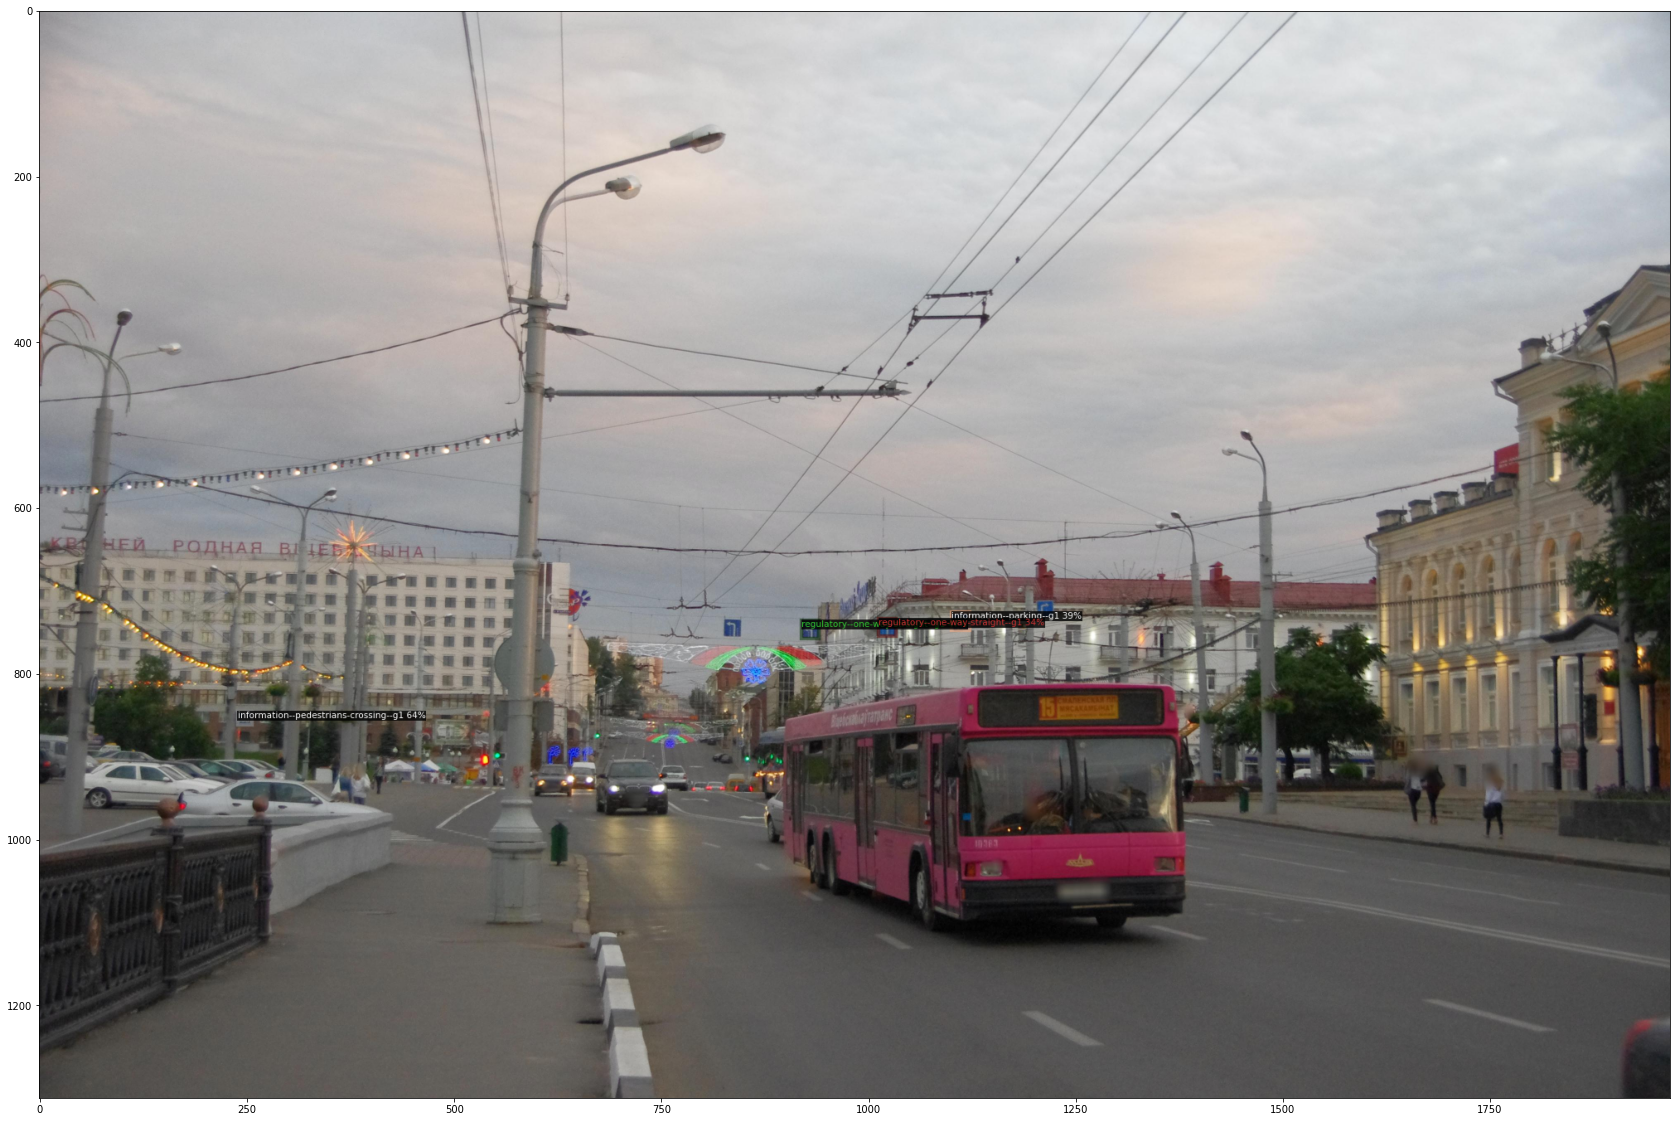

In [26]:
plt.figure(figsize=(30,20))
im = cv2.imread(d["file_name"])
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1],
               metadata=signs_metadata, 
               scale=0.5#, 
               #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
              )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image())
print(outputs)

In [14]:
outputs

{'instances': Instances(num_instances=0, image_height=2160, image_width=3840, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], dtype=torch.int64)])}